In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
from tensorflow import keras

from run_utils import setup
from configs import mve_config as config
from losses import MSE
from models import unet
from capsa import MVEWrapper
from callbacks import MVEVisCallback
from utils import notebook_select_gpu, load_depth_data, load_apollo_data, \
    get_normalized_ds, visualize_depth_map

notebook_select_gpu(0)

4 Physical GPUs, 1 Logical GPU


In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[:config.N_TRAIN], y_train[:config.N_TRAIN])
ds_test = get_normalized_ds(x_test, y_test)

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

In [4]:
model_name = 'notebook_mve'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

## Train

In [ ]:
vis_callback = MVEVisCallback(checkpoints_path, logs_path, model_name, ds_train, ds_test)

their_model = unet()
model = MVEWrapper(their_model)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LR),
    loss=MSE,
)

history = model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
    callbacks=[vis_callback],
)

In [ ]:
visualize_depth_map(model, ds_train, vis_path, 'train', is_show=True)
visualize_depth_map(model, ds_test, vis_path, 'test', is_show=True)
visualize_depth_map(model, ds_ood, vis_path, 'ood', is_show=True)

In [ ]:
# loss curves and visualisations

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir config.LOGS_PATH --host localhost --port 8888

## Load trained model

In [5]:
from utils import load_model, select_best_checkpoint

path, model_name = select_best_checkpoint(config.MODEL_PATH)
trained_model = load_model(path, model_name, ds_train)

Successfully loaded weights from /data/capsa/depth/results/mve/20220827-211807/checkpoints/-2.262vloss_51300iter.tf.


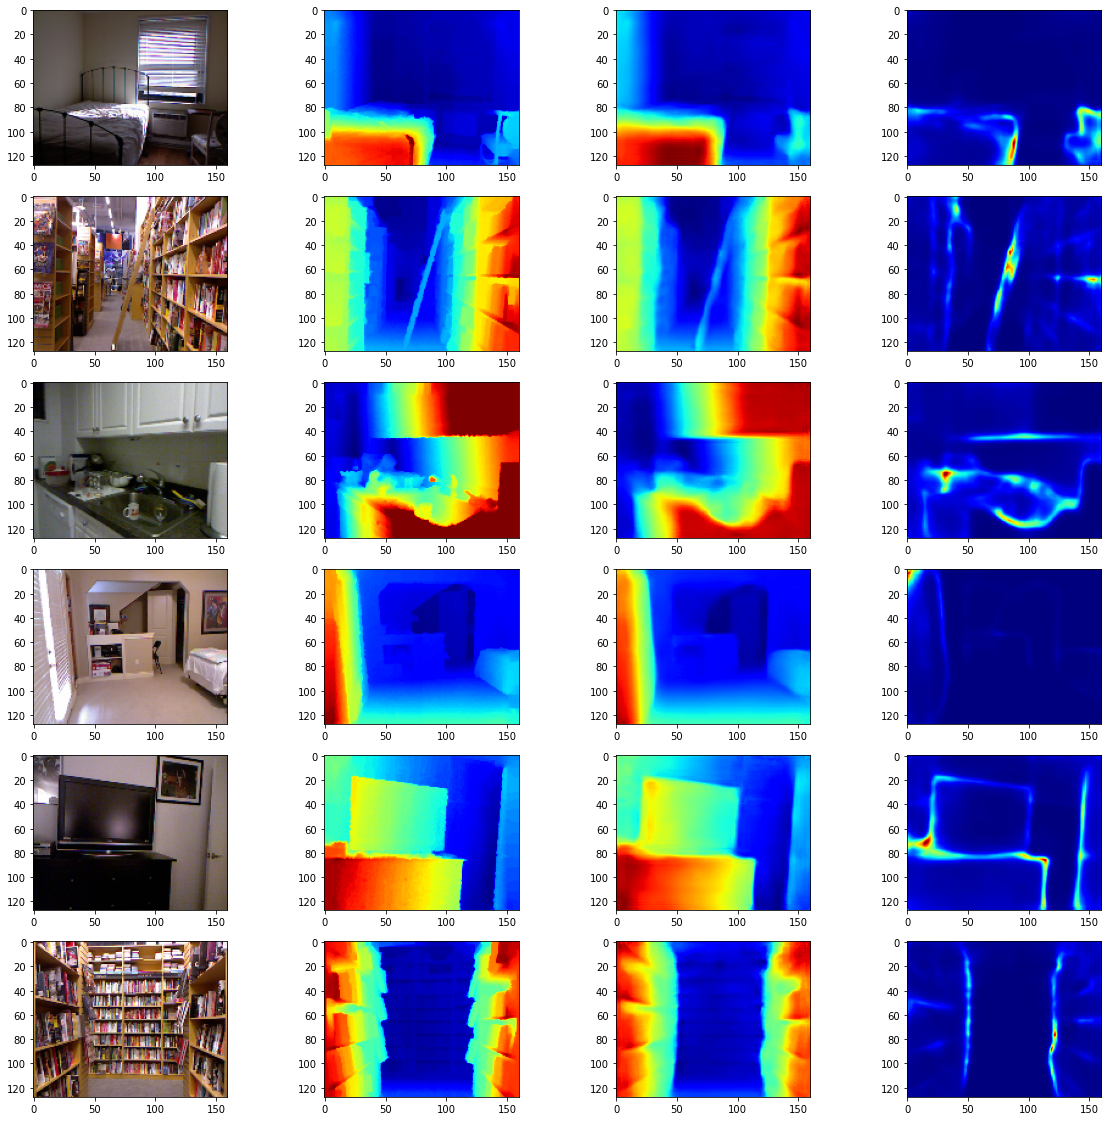

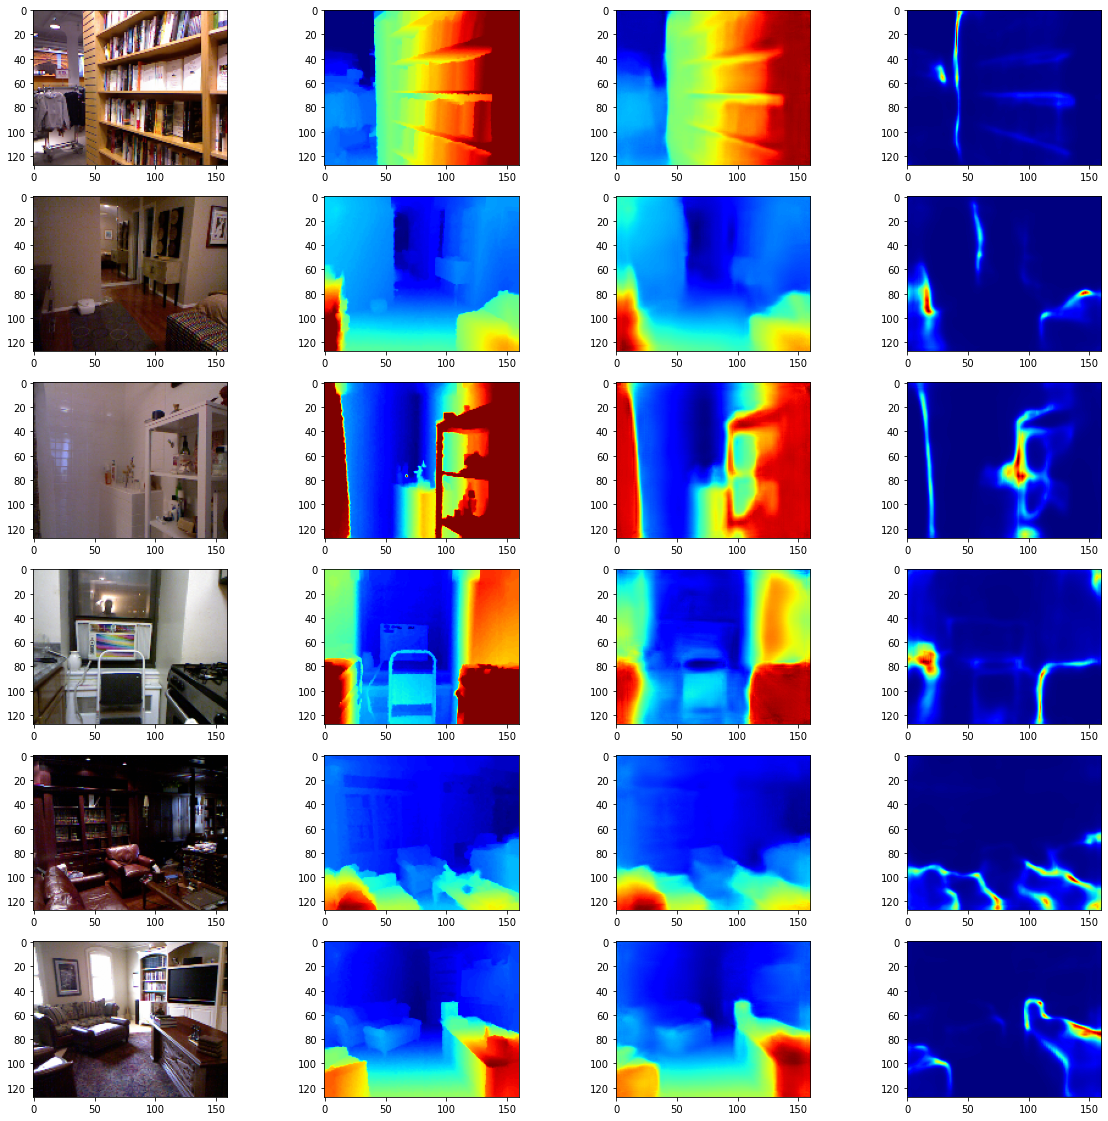

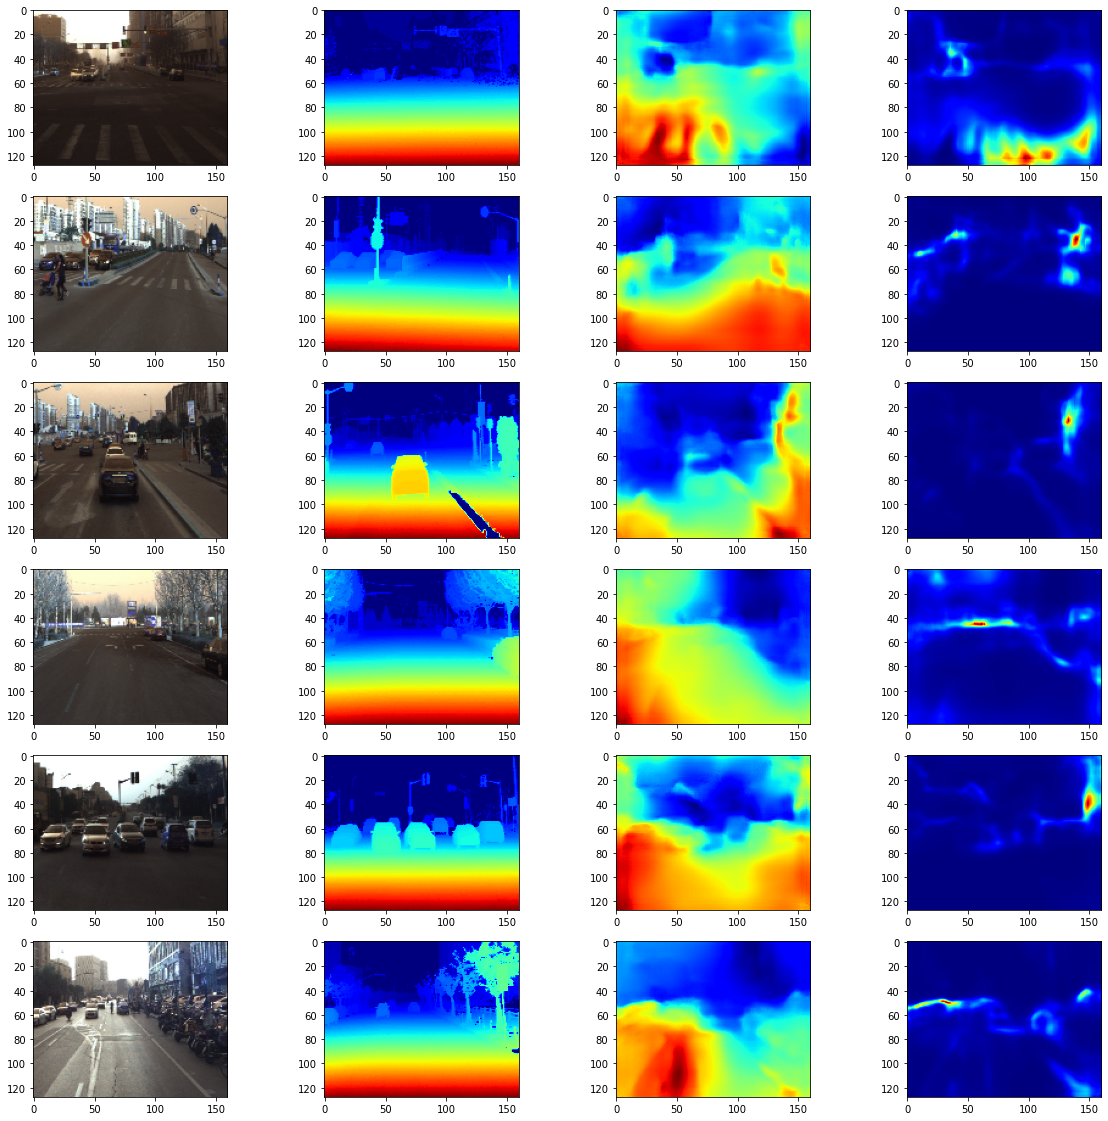

In [6]:
visualize_depth_map(trained_model, ds_train, vis_path, f'trained_train', is_show=True)
visualize_depth_map(trained_model, ds_test, vis_path, f'trained_test', is_show=True)
visualize_depth_map(trained_model, ds_ood, vis_path, f'trained_ood', is_show=True)